# Practical: Graph Neural Networks
In this practical, we will build a GNN and use QM9 dataset to run some calculations.

In [ ]:
# CPU: For macOS (Apple Silicon) or Windows
!pip3 install torch torchvision torchaudio torch_geometric

# For macOS (Apple Silicon)
#!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

# For NVIDIA GPUs: check PyTorch website for more details https://pytorch.org/

You can verify whether your GPU compatibility by running the following command in your terminal.

In [113]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
elif torch.cuda.is_available():
    cuda_device = torch.device("cuda")
    x = torch.ones(1, device=cuda_device)
    print (x)
else:
    print ("No GPU has been not found.")


tensor([1.], device='mps:0')


## PyTorch Geometric
PyTorch Geometric is a library for deep learning on irregular structures like graphs. It is built on top of PyTorch and provides a set of tools and utilities for working with graph data.

### Graph
You can define a graph using the `torch_geometric.data.Data` class. A graph is defined by its nodes and edges, where each node can have features and each edge can have weights.

In [5]:
from torch_geometric.data import Data
import torch

# 1. Node features: let's say 4 nodes, each has 3 features
x = torch.tensor([
    [1.0, 2.0, 3.0],   # node 0
    [4.0, 5.0, 6.0],   # node 1
    [7.0, 8.0, 9.0],   # node 2
    [10.0, 11.0, 12.0] # node 3
], dtype=torch.float)

# 2. Edges (source → target)
# Let's connect 0→1, 1→0, 2→3, 3→2 (undirected graph by listing both directions)
edge_index = torch.tensor([
    [0, 1, 2, 3],  # source nodes
    [1, 0, 3, 2]   # target nodes
], dtype=torch.long)

# 3. Edge features: one per edge, e.g., distance, bond type (2 features per edge here)
edge_attr = torch.tensor([
    [0.1, 0.2],  # 0→1
    [0.3, 0.4],  # 1→0
    [0.5, 0.6],  # 2→3
    [0.7, 0.8]   # 3→2
], dtype=torch.float)

# 4. (Optional) Node or graph labels — here let’s use node classification (1 label per node)
y = torch.tensor([0, 1, 0, 1], dtype=torch.long)

# Bundle everything into a PyG Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

print(data)


Data(x=[4, 3], edge_index=[2, 4], edge_attr=[4, 2], y=[4])


You can visualize this graph using `torch_geometric.utils.to_networkx` and `matplotlib`. The following code snippet shows how to create a graph with 4 nodes and 4 edges, and visualize it.

In [6]:
from torch_geometric.utils import to_networkx
import networkx as nx
import plotly.graph_objects as go

G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G)

# Build node positions
node_x, node_y = zip(*[pos[n] for n in G.nodes()])
node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers+text',
    marker=dict(size=20, color='skyblue'),
    text=list(map(str, G.nodes())), textposition='top center',
    hoverinfo='text'
)

# Build edge lines
edge_x = []
edge_y = []
for src, dst in G.edges():
    x0, y0 = pos[src]
    x1, y1 = pos[dst]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y, line=dict(width=2, color='gray'),
    hoverinfo='none', mode='lines'
)

# Display
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title="Graph Example", showlegend=False)
fig.show()




## QM9 Dataset
The QM9 dataset contains 134k small organic molecules with up to 9 heavy atoms (C, O, N, F).

More information about QM9 dataset can be found below:
https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

In [1]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import torch
import numpy as np
from torch_geometric.datasets.qm9 import QM9
import torch.nn as nn
from torch_geometric.nn import NNConv, global_add_pool
import torch.nn.functional as F

len_data = 10000 # for saving of our time, we will not use the whole dataset.
data = QM9(root= './tmp')[:len_data]
print(f"Data length: {len(data)}, Feature length: {data.num_features}, Target length: {data.num_classes}")


Data length: 10000, Feature length: 11, Target length: 19


In [4]:
data_to_show = data[6]
print(data_to_show)

G = to_networkx(data_to_show, to_undirected=True)
pos = nx.spring_layout(G)

# Build node positions
node_x, node_y = zip(*[pos[n] for n in G.nodes()])
node_trace = go.Scatter(
    x=node_x, y=node_y, mode='markers+text',
    marker=dict(size=20, color='skyblue'),
    text=list(map(str, G.nodes())), textposition='top center',
    hoverinfo='text'
)

# Build edge lines
edge_x = []
edge_y = []
for src, dst in G.edges():
    x0, y0 = pos[src]
    x1, y1 = pos[dst]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y, line=dict(width=2, color='gray'),
    hoverinfo='none', mode='lines'
)

# Display
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title="Graph Example", showlegend=False)
fig.show()




Data(x=[8, 11], edge_index=[2, 14], edge_attr=[14, 4], y=[1, 19], pos=[8, 3], idx=[1], name='gdb_7', z=[8])


## Define the GNN
- `NNConv` is a convolutional layer that uses a neural network to compute the weights of the edges. It takes as input the node features and the edge features, and outputs the new node features.
- `global_mean_pool` is a pooling layer that computes the mean of the node features for each graph in the batch. It takes as input the node features and the batch indices, and outputs the pooled node features.
- `Linear` is a fully connected layer that takes as input the pooled node features and outputs the final prediction.
- `ReLU` is an activation function that applies the rectified linear unit (ReLU) function to the input. It is used to introduce non-linearity in the model.

In [ ]:
class MoleculeNet(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, num_node_features*32),
        )
        conv2_net = nn.Sequential(
            nn.Linear(num_edge_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32*16),
        )
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)

        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
    
    def forward(self,data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr

        # First layer
        x = F.relu(self.conv1(x, edge_index, edge_attr))

        # Second layer
        x = F.relu(self.conv2(x, edge_index, edge_attr))

        x = global_add_pool(x, batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)

        return output



In [119]:
print(MoleculeNet(11, 4))

MoleculeNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


Then we can create data loader for our dataset.

In [121]:


# Splitting the dataset into train, validation, and test sets, here we use 80% for training, 10% for validation, and 10% for testing
train_set, valid_set, test_set = random_split(data, [int(0.8*len_data), 
                                                     int(0.1*len_data),
                                                     int(0.1*len_data)],)

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)



Then we initialize the model, setup optimizer and loss function.

In [122]:

# Initialize the model
qm9_node_features, qm9_edge_features = 11, 4
gnn = MoleculeNet(qm9_node_features, qm9_edge_features)

# Initialize the optimizer
optimizer = Adam(gnn.parameters(), lr=0.01)

# Load model to GPU if available
if torch.cuda.is_available():
    gnn = gnn.to('cuda')
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    gnn = gnn.to('mps')
    device = torch.device('mps')
else:
    gnn = gnn.to('cpu')

gnn.to(device)

# Setup loss function
loss_fn = F.mse_loss

# Setup training loop
epoch = 10
# target_idx = 1 -> isotropic polarizability in the unit of a0^3 https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html
target_idx = 1


Then we can start training

In [ ]:
print(f"Training on {device}")
for epoch in range(epoch):
    epoch_loss = 0
    total_graphs = 0
    gnn.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = gnn(batch)
        # calculate the loss
        loss = loss_fn(pred, batch.y[:, target_idx].unsqueeze(1))
        # calculate the gradient
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        # update the parameters
        optimizer.step()
        
    train_avg_loss = epoch_loss / total_graphs
    
    val_loss = 0
    total_graphs = 0
    gnn.eval()
    with torch.no_grad(): # disable gradient calculation
        for batch in valid_loader:
            batch = batch.to(device)
            pred = gnn(batch)
            loss = loss_fn(pred, batch.y[:, target_idx].unsqueeze(1))
            val_loss += loss.item()
            total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    print(f"Epoch {epoch}:, Train Average Loss: {train_avg_loss}, Validation Average Loss: {val_avg_loss}")
# Save the model
torch.save(gnn.state_dict(), './tmp/moleculenet.pth')


Training on mps
Epoch 0:, Train Average Loss: 2.872069504737854, Validation Average Loss: 0.3707349548339844
Epoch 1:, Train Average Loss: 0.1330656726360321, Validation Average Loss: 0.07437166023254395
Epoch 2:, Train Average Loss: 0.0656943690776825, Validation Average Loss: 0.04003890895843506
Epoch 3:, Train Average Loss: 0.04504652512073517, Validation Average Loss: 0.03344046401977539
Epoch 4:, Train Average Loss: 0.038349803507328036, Validation Average Loss: 0.030948024272918703
Epoch 5:, Train Average Loss: 0.03820364385843277, Validation Average Loss: 0.028867740631103516
Epoch 6:, Train Average Loss: 0.03554772961139679, Validation Average Loss: 0.03817344617843628
Epoch 7:, Train Average Loss: 0.034816804349422456, Validation Average Loss: 0.028834184646606444
Epoch 8:, Train Average Loss: 0.03213495522737503, Validation Average Loss: 0.02823439073562622
Epoch 9:, Train Average Loss: 0.03261125546693802, Validation Average Loss: 0.025330042362213135


After we train this model, we can use this model for our predictions.

In [ ]:
gnn.eval()
predictions = []
real = []
total_graphs = 0
total_squared_error = 0

with torch.no_grad():
    for batch in test_loader:
        pred = gnn(batch.to(device))
        target = batch.y[:, target_idx].unsqueeze(1)

        # Move to CPU for numpy conversion
        predictions.append(pred.cpu().detach().numpy())
        real.append(target.cpu().detach().numpy())

        squared_error = torch.sum((pred - target) ** 2).item()
        total_squared_error += squared_error
        total_graphs += batch.num_graphs
        
rmse=  (total_squared_error/total_graphs) ** 0.5
print(f"RMSE: {rmse}")

real = np.concatenate(real)
predictions = np.concatenate(predictions)


RMSE: 2.5985456654050383


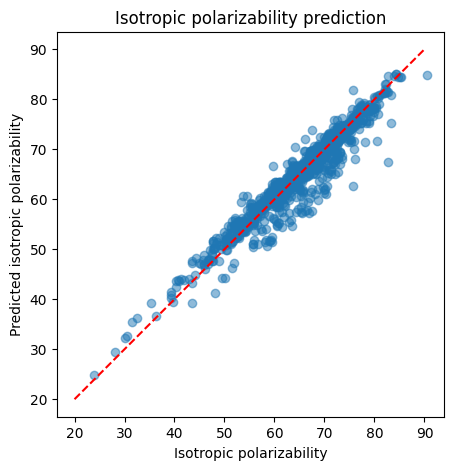

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.title('Isotropic polarizability prediction')
plt.scatter(real, predictions, alpha=0.5)
plt.xlabel('Isotropic polarizability')
plt.ylabel('Predicted isotropic polarizability')
plt.gca().set_aspect('equal')

x = np.linspace(20, 90, 100)
plt.plot(x, x, color='red', linestyle='--')
plt.show()

